# Causal Inference in Internal space with Angle space responses

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import uniformised_space_utils as usu
import utils
from scipy.stats import vonmises, circmean
import matplotlib.pyplot as plt
from custom_causal_inference import CustomCausalInference
from repulsion_hypothesis import repulsion_value

## Setup

In [ ]:
num_sim = 10000
D = 250  # grid dimension 
angle_gam_data_path = 'D:/AK_Q1_2024/Gatsby/data/base_bayesian_contour_1_circular_gam/base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='D:/AK_Q1_2024/Gatsby/uniform_model_base_inv_kappa_free.pkl'
# Load the GAM.
with open(angle_gam_data_path, 'rb') as file:
    gam_data = pickle.load(file)
# Load the uniformising function data.
with open(unif_fn_data_path, 'rb') as file:
    unif_fn_data = pickle.load(file)
# Initialise uniformising function map.
unif_map = usu.UnifMap(data=unif_fn_data)
unif_map.get_cdf_and_inverse_cdf()
grid = np.linspace(-np.pi, np.pi, num=D)

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

In [31]:
def get_s_n_and_t(grid, gam_data, step=1):
    indices = np.arange(len(grid), step=step)
    t, s_n = np.meshgrid(grid[indices], grid[indices], indexing='ij')
    r_n = gam_data['full_pdf_mat'][indices, :, 2]
    r_n = r_n[:, indices]
    return s_n, t, r_n

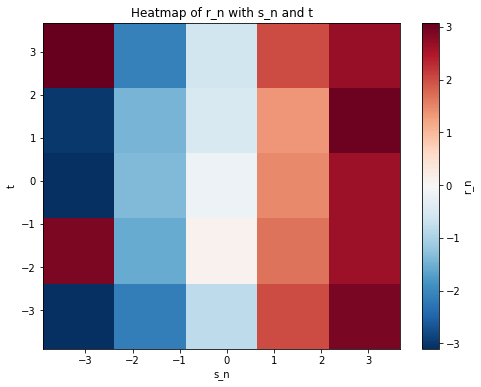

In [38]:
s_n, t, r_n = get_s_n_and_t(grid, gam_data, step=10)
step=len(s_n)//4
indices = np.arange(0, s_n.shape[0], step=step)
s_n = s_n[indices][:, indices]
t = t[indices][:, indices]
r_n = r_n[indices][:, indices]
plt.figure(figsize=(8, 6))
plt.pcolormesh(s_n[0], t[:,0], r_n, shading='auto', cmap='RdBu_r')
plt.colorbar(label='r_n')

# Add labels and title
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of r_n with s_n and t')
plt.show()

## Causal inference

In [39]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
kappa1, kappa2 = 50, 70

Running causal cue combination for t=(25,), s_n=(25,), r_n=(25,)


In [ ]:
t_samples = vonmises(loc=ut, kappa=kappa1).rvs(size=(num_sim, ut.shape[0]))
s_n_samples = vonmises(loc=us_n, kappa=kappa2).rvs(size=(num_sim, us_n.shape[0]))
decision_rules = ['mean']
response_dict = {}
p_commons = [0., 0.2, 0.5, 0.7, 1]
for decision_rule in decision_rules:
        model = CustomCausalInference(decision_rule=decision_rule)
        response_dict[decision_rule] = {'responses': [], 
                                        'mean_sn_estimate': [],
                                        'mean_t_estimate': [],
                                        'posterior_p_common': [],
                                        }
        for pc_idx, p_common in enumerate(p_commons):
            # Add "optimal" estimates for s_n and t for every pair of samples assuming P(C=1)=p_common.
            response_dict[decision_rule]['responses'].append(model.bayesian_causal_inference(x_v=t_samples, 
                                                                                x_a=s_n_samples, 
                                                                                sigma_v=kappa1, 
                                                                                sigma_a=kappa2,
                                                                                mu_p=None, 
                                                                                sigma_p=None,
                                                                                pi_c=p_common))
            response_dict[decision_rule]['posterior_p_common'].append(model.posterior_prob_common_cause(x_v=t_samples, 
                                                                                x_a=s_n_samples, 
                                                                                sigma_v=kappa1, 
                                                                                sigma_a=kappa2,
                                                                                mu_p=None, 
                                                                                sigma_p=None,
                                                                                pi_c=p_common))
            # Find circular mean across "optimal" estimates for samples.
            mean_t_est = circmean(unif_map.unif_space_to_angle_space(response_dict[decision_rule]['responses'][-1][0]), 
                                  low=-np.pi, high=np.pi, axis=0)
            mean_sn_est = circmean(unif_map.unif_space_to_angle_space(response_dict[decision_rule]['responses'][-1][1]),
                                  low=-np.pi, high=np.pi, axis=0)
            response_dict[decision_rule]['mean_sn_estimate'].append(mean_sn_est)
            response_dict[decision_rule]['mean_t_estimate'].append(mean_t_est)

In [89]:
def plot_estimate(us_n, ut, r_n, mu_x_dim, estimate, est_label, plot_heatmap):
    plt.scatter(us_n, ut, label='u_t')
    plt.scatter(us_n, r_n, label='r_n')
    plt.scatter(us_n, estimate, label=est_label)
    plt.title(f'Values for {est_label}')
    plt.legend()
    plt.show()
    plt.clf()
    if plot_heatmap:
        uts_unq = ut.reshape(mu_x_dim,mu_x_dim)[:,0]
        plt.pcolormesh(us_n[:mu_x_dim], uts_unq, 
                        estimate.reshape(mu_x_dim,mu_x_dim), 
                        shading='auto', cmap='RdBu_r')
        plt.colorbar(label=est_label)
        plt.title(f'Heatmap for {est_label}')
        plt.show()
        plt.clf()

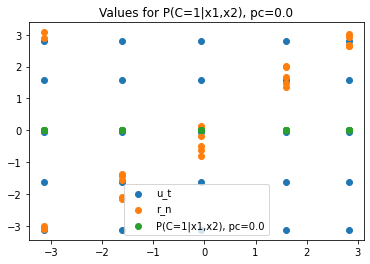

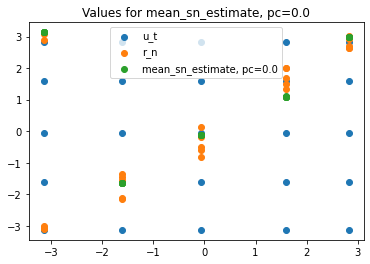

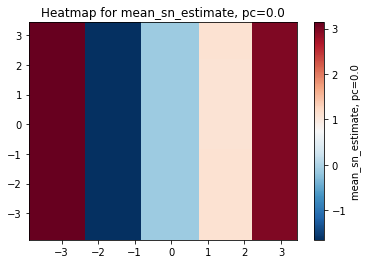

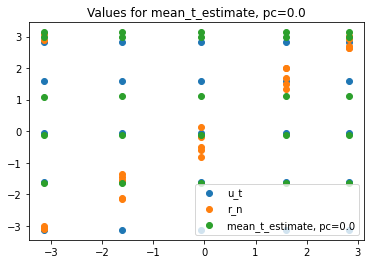

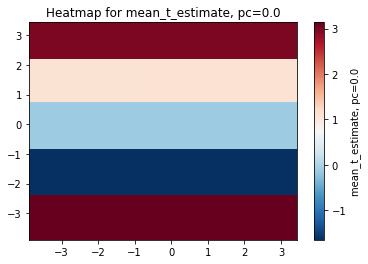

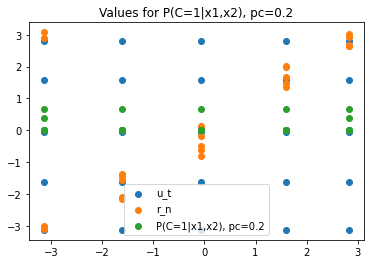

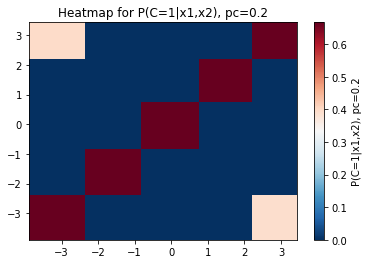

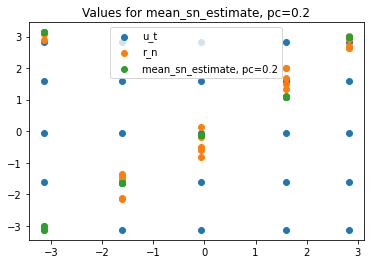

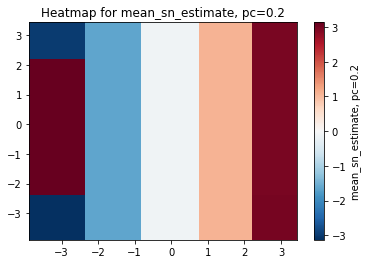

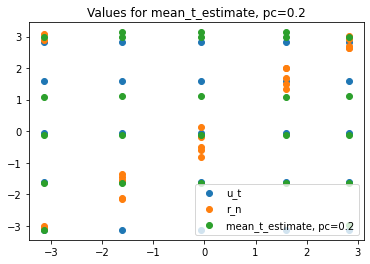

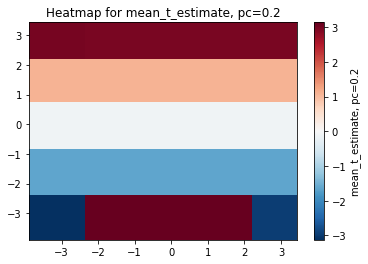

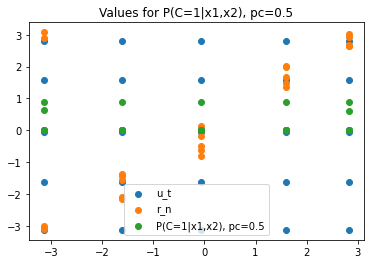

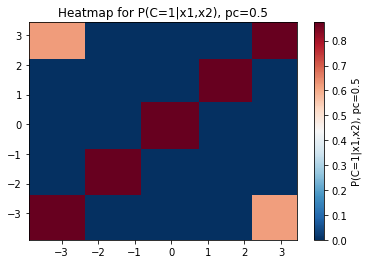

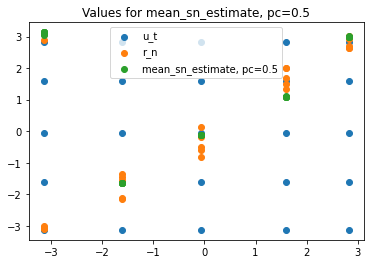

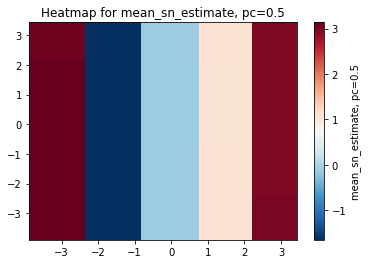

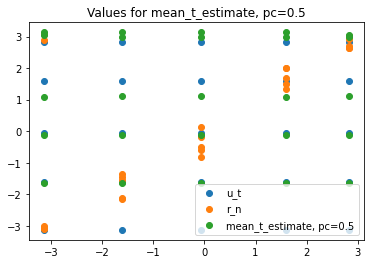

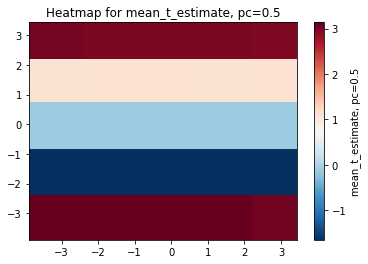

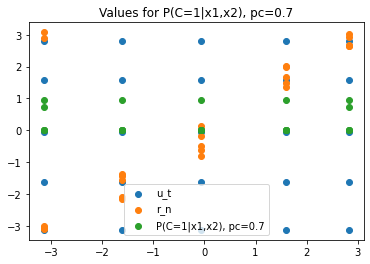

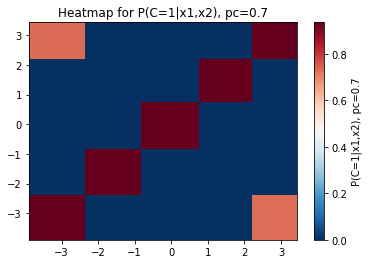

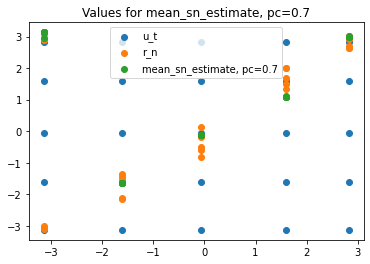

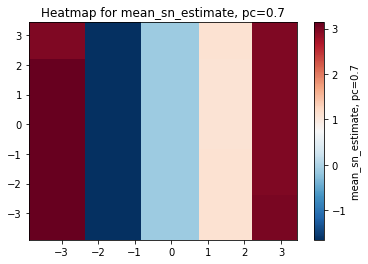

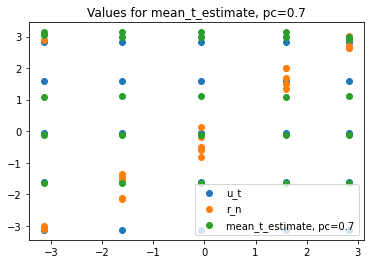

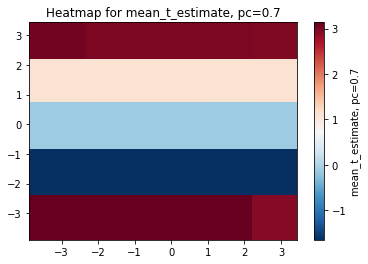

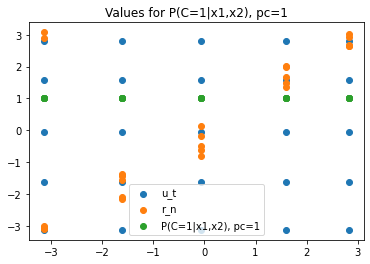

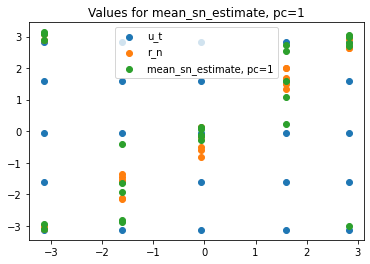

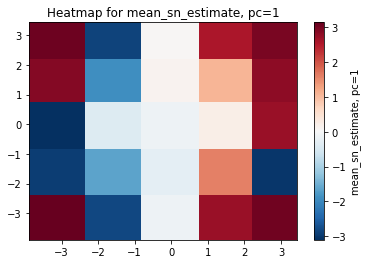

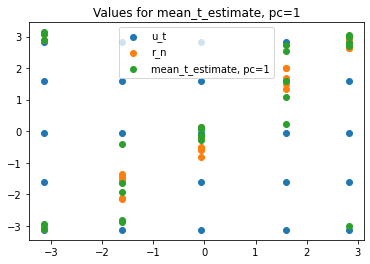

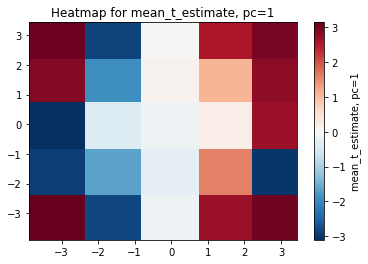

<Figure size 432x288 with 0 Axes>

In [90]:
mu_x_dim = 5
assert (len(us_n) == mu_x_dim**2)
for decision_rule in decision_rules:
    #plt.scatter(us_n, us_n, label='us_n')
    for i, p_c in enumerate(p_commons):
       plot_heatmap = (p_c < 1) and (p_c > 0)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['posterior_p_common'][i].mean(axis=0),
                     est_label=f'P(C=1|x1,x2), pc={p_c}', 
                     plot_heatmap=plot_heatmap)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['mean_sn_estimate'][i],
                     est_label=f'mean_sn_estimate, pc={p_c}', 
                     plot_heatmap=True)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['mean_t_estimate'][i],
                     est_label=f'mean_t_estimate, pc={p_c}', 
                     plot_heatmap=True)